In [1]:
# !pip install opencv-python
# !pip install ultralytics

In [1]:
from ultralytics import YOLO, ASSETS
from ultralytics.engine.results import Results
from ultralytics.utils.ops import scale_boxes
import cv2
import matplotlib.pyplot as plt
import numpy as np
from types import MethodType

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
from Code.YOLO.Get_feature_yolo import _predict_once, non_max_suppression, get_object_features

In [3]:
# Initialize the model YOLOv8
def init_yolo(path_yolo):
    model = YOLO(path_yolo)
    # Monkey patch method
    model.model._predict_once = MethodType(_predict_once, model.model)

    #model.model.yaml # Find the FPN output layers
    _ = model(ASSETS / "bus.jpg", save=False, embed=[15, 18, 21, 22])  # 15, 18, 21 are the default FPN levels that are used by the head.

    return model



In [4]:
# get atribution of objects:
def get_object(img_path, model):
    # # Run inference
    img = cv2.imread(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # img = preprocess_image(img_path)
    prepped = model.predictor.preprocess([img])
    result = model.predictor.inference(prepped)

    # This would return the NMS output in xywh format and the idxs of the predictions that were retained.
    output, idxs = non_max_suppression(result[-1][0], in_place=False)

    # Get features of every detected objected in the final output.
    obj_feats = get_object_features(result[:3], idxs[0].tolist())
    output[0][:, :4] = scale_boxes(prepped.shape[2:], output[0][:, :4], img.shape) # #x1, y1, x2, y2, conf, class_id

    result = Results(img, path="", names=model.predictor.model.names, boxes=output[0])
    result.feats = obj_feats

    return result



Time for frame 0: 0.298089 seconds
Match found for current index 0 at template index 0
Match found for current index 1 at template index tensor([1, 9])
Match found for current index 2 at template index tensor([2, 5, 8])
Match found for current index 3 at template index 4
Match found for current index 4 at template index 15
Match found for current index 5 at template index tensor([2, 5, 8])
Match found for current index 6 at template index tensor([ 0, 18])
Match found for current index 7 at template index tensor([ 6, 12])
Match found for current index 9 at template index tensor([ 1,  9, 16])
Match found for current index 10 at template index tensor([ 3, 10])
Match found for current index 11 at template index 13
Match found for current index 12 at template index 15
Match found for current index 13 at template index tensor([ 7, 10, 19])
Match found for current index 14 at template index tensor([ 6, 13, 14])
Match found for current index 15 at template index 11
Match found for current ind

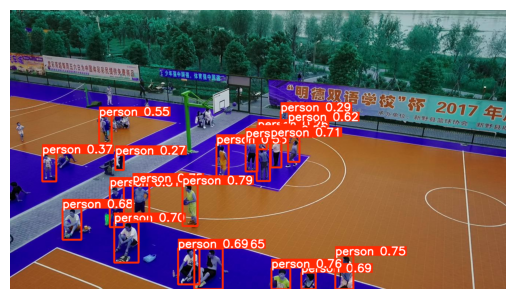

In [5]:
import os
import time
import torch
import cv2
from torch.nn.functional import cosine_similarity

# Path to the video sequence folder
seq_path = r"Data\VisDrone2019_MOT\VisDrone2019-MOT-val\sequences\uav0000086_00000_v"
path_yolo = 'yolov8n.pt'

model = init_yolo(path_yolo)


# Load frames
frames = sorted([os.path.join(seq_path, img) for img in os.listdir(seq_path)])
template_features = None

for index, frame_path in enumerate(frames):
    # Start the timer
    start_time = time.time()

    result = get_object(frame_path, model)
    obj_feats = result.feats
    
    # Convert result to OpenCV format (if necessary)
    img_result = result.plot()
    
    # Show the image in a window
    cv2.imshow("Detection Result", img_result)

    if index == 0:
        template_features = obj_feats
    else:
        for current_index, current_feature in enumerate(obj_feats):
            current_feature = current_feature.unsqueeze(dim=0)

            # Calculate cosine similarities with all template features
            similarities = torch.cosine_similarity(current_feature, template_features)

            # Get indices of similarities that exceed the threshold
            matching_indices = torch.nonzero(similarities > 0.8).squeeze()  # Indices of matches

            if matching_indices.numel() == 0:  # No matches found
                # Update template features if no match found
                template_features = torch.cat((template_features, current_feature), dim=0)
            else:
                # You can access the indices of matches if needed
                print(f"Match found for current index {current_index} at template index {matching_indices}")

    # Stop the timer
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time for frame {index}: {elapsed_time:.6f} seconds")
    
    # Break after showing the first frame for demonstration; remove or adjust this for more frames
    if index == 50:  # Change this to show more frames if needed
        break

    # Wait for a short period to display the image, and break on any key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cv2.destroyAllWindows()


# result = Results(img, path="", names=model.predictor.model.names, boxes=boxes)

plt.imshow(result.plot())
plt.axis('off')  # Hide axes
plt.show()


Problem 1: Detecting objects:
  - In some cases model can not detect some objects, although detected precious frames

In [6]:
len(template_features)

69

In [10]:
dir(result)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_keys',
 'boxes',
 'cpu',
 'cuda',
 'feats',
 'keypoints',
 'masks',
 'names',
 'new',
 'numpy',
 'obb',
 'orig_img',
 'orig_shape',
 'path',
 'plot',
 'probs',
 'save',
 'save_crop',
 'save_dir',
 'save_txt',
 'show',
 'speed',
 'summary',
 'to',
 'to_csv',
 'to_df',
 'to_json',
 'to_xml',
 'tojson',
 'update',
 'verbose']

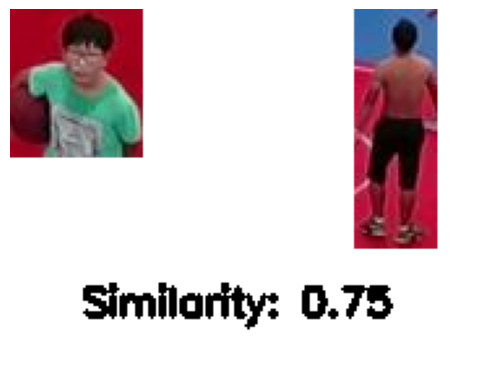

In [16]:
# You can now easily access the box along with the features of that particular box
(box1, box2), (feat1, feat2) = result.boxes.xyxy[[1,5]], result.feats[[1,5]]

# Crop the box from the original image
x1, y1, x2, y2 = map(int, box1)
img = result.orig_img
crop1 = img[y1:y2, x1:x2]

# Crop the box from the original image
x1, y1, x2, y2 = map(int, box2)
crop2 = img[y1:y2, x1:x2]

# Create a canvas to display the crops side-by-side
canvas = np.ones((max(crop1.shape[0], crop2.shape[0]) + 50, crop1.shape[1] + crop2.shape[1] + 100, 3), dtype=np.uint8) * 255
canvas[:crop1.shape[0], :crop1.shape[1]] = crop1
canvas[:crop2.shape[0], 100+crop2.shape[1]:100+crop2.shape[1]*2] = crop2

# Calculate similarity
similarity = cosine_similarity(feat1, feat2, dim=0).item()

# Put the similarity text on the canvas
# cv2.putText(canvas, f'Similarity: {similarity:.2f}', ((crop1.shape[1] + crop2.shape[1]) // 3, crop1.shape[0] + 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.putText(canvas, f'Similarity: {similarity:.2f}', 
            ((crop1.shape[1] + crop2.shape[1]) // 3, crop1.shape[0] + 60),  # Adjusted Y position
            cv2.FONT_HERSHEY_SIMPLEX, 0.5,  # Smaller font scale
            (0, 0, 0), 2)


# Display the canvas
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()